<a href="https://colab.research.google.com/github/Sirabhop/Kaggle_Challenges/blob/master/Challenge_1_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns

from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
os.chdir("/content/drive/My Drive/My Project/Kaggle/Challenge#1_Titanic")

In [25]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [26]:
df['PassengerId'] = df['PassengerId'].astype('object')
#df['Survived'] = df['Survived'].astype('category') #0 is no, 1 is yes
df['Pclass'] = df['Pclass'].astype('category')
df['Pclass'].cat.reorder_categories([1, 2, 3], ordered = True)
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

In [27]:
df.drop(['Name', 'Cabin', 'Ticket'], axis = 1, inplace = True)
df.dropna(subset = ['Embarked'], axis = 0, how = 'any', inplace = True)
df['Age'].fillna(df['Age'].mean(), inplace = True)

df.reset_index(inplace = True, drop = True)

In [28]:
df['Embarked'].replace({'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}, inplace = True)
df['Pclass'].replace({1: 'First class', 2: 'Second class', 3: 'Third class'}, inplace = True)


In [36]:
df['Survived'].replace({0: 'Death', 1: 'Survived'}, inplace = True)

The question is who gonna survive from shipwreak? from those features I can draw 3 assumption


1. **The number of sibling, children, & parent** are effected the chance of survive because the titanic passenger would do ever it take to save their relatives.
2. **The room** where passenger stayed affected too, the chance of survival may depend on how easy for them to acquire the emergency boat.
3. **The status of their ticket**, one who are VIP guest on board may thought the crew cabin would rushed out to help them instead of economics passengers.
4. **Embarkation** may determined their belongings which increase time to escape





![Sea lanes of Titanic](https://drive.google.com/uc?export=view&id=1DLHzbthFAdZboIGqbsKPm5utA-PB8MSL)

the route start from Southampton (UK) > Cherbourg (FR) > Queenstown (IR)


In [8]:
df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,Third class,male,22.000000,1,0,7.2500,Southampton
1,2,1,First class,female,38.000000,1,0,71.2833,Cherbourg
2,3,1,Third class,female,26.000000,0,0,7.9250,Southampton
3,4,1,First class,female,35.000000,1,0,53.1000,Southampton
4,5,0,Third class,male,35.000000,0,0,8.0500,Southampton
...,...,...,...,...,...,...,...,...,...
884,887,0,Second class,male,27.000000,0,0,13.0000,Southampton
885,888,1,First class,female,19.000000,0,0,30.0000,Southampton
886,889,0,Third class,female,29.642093,1,2,23.4500,Southampton
887,890,1,First class,male,26.000000,0,0,30.0000,Cherbourg


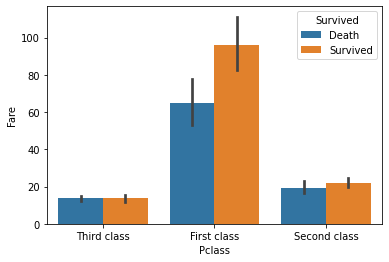

In [37]:
ax = sns.barplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = df)

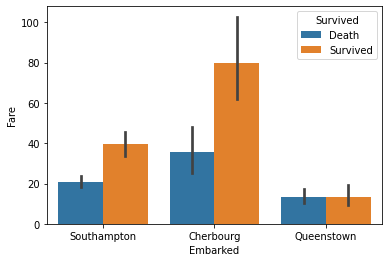

In [41]:
ax = sns.barplot(x = 'Embarked', y = 'Fare', hue = 'Survived', data = df)

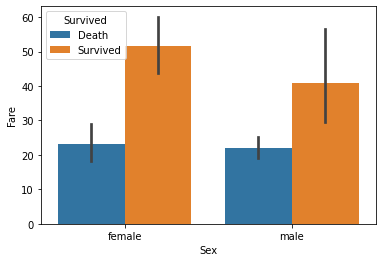

In [42]:
ax = sns.barplot(x = 'Sex',y = 'Fare', hue = 'Survived', data = df)

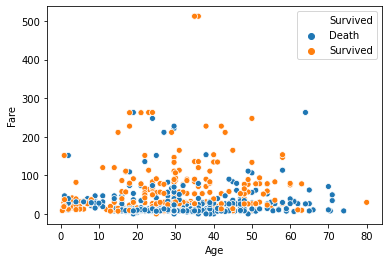

In [45]:
ax = sns.scatterplot(x = 'Age', y = 'Fare', hue = 'Survived', data = df)

In [ ]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 0)
y_train, y_test = train_test_split(y, test_size = 0.2, random_state = 0)

In [ ]:
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)